# UCSD Mentor Program 2016

## Student: Mong H. Ng
## Mentor: Dr. Giorgio Quer

This Jupyter notebook is a diary-like notebook that recorded the research I did under Dr. Giorgio Quer. We mainly focused on PPG and ECG signal data extraction and alignment between ECG-derived RRIT signal and PPG-derived RRIT signal.

Table of Content
<ol>
<li><a href="#Abstract">Abstract</a></li>
<li><a href="#Introduction">Introduction</a></li>
<li>
    <a href="#The-Senario">The Senario</a>
    <ol>
        <li><a href="#What-we-need-to-do">What we need to do</a></li>
    </ol>
</li>
<li><a href="#Hrm-Files">Hrm Files</a></li>
<li><a href="#Video-Processing">Video Processing</a></li>
<li><a href="#R-Peaks-Detection">R-Peaks Detection</a></li>
<li><a href="#Looking-at-Data-in-a-Statistical-Standpoint">Looking at Data in a Statistical Standpoint</a></li>
<li><a href="#The-Alignment">The Alignment</a></li>
<li><a href="#Result-of-the-Alignment">Result of the Alignment</a></li>
<li><a href="#Visual-Confirmation">Visual Confirmation</a></li>
<li><a href="#Conclusion">Conclusion</a></li>
</ol>

## Abstract

The focus of our research is on the computation of RR interval time series. In the first part of our work, we extract the RR intervals from the videos of a fingertip. We explore means of extracting RR signals by converting each frame of the video into a representative number (average color intensity) that can be quantitatively analyzed. This is the principle at the basis of the PPG (Photoplethysmography) signal analysis. In the second part of our work, we align the RR signals that we obtained previously with another longer RR signal (from the same subject and recorded at the same time) obtained from an ECG (Electrocardiography) sensor. We then align each PPG-derived RR with the ECG-derived RR using linear interpolation and minimizing the absolute value of their distance.

## Introduction

R-peak and RR Intervals: In a electrocardiography graph, we call the peaks R-peaks and the distance between consecutive R-peaks RR interval.

ECG sensors: Sensors that can provide RR signal by measuring the electric signal generated from the expansion and contraction of heart chamber. They are the most accurate heart rate sensors.

PPG sensors: Light-based sensors that provide RR signal by detecting the color change caused by blood flow in a body part. A variety of these devices exist, and even a smartphone camera can serve as a PPG sensor. For example, if a person places his finger on the flashlight of a smartphone, the tip of the finger would exhibit changes in redness as blood flow comes and goes. The camera would then record this change in a video.

## The Senario

Two subjects each carry an ECG sensor while simultaneously pressing his or her finger against a smart phone camera (acting as the PPG sensor). For ten minutes, the ECG sensors record the RR interval, while the phones record 10 short 30-second videos of the person’s fingertip at 30 frames per second. Our goal is to align the 20 PPG signals correctly with one of the two long ECG signals.

### What we need to do

The ECG-derived RRIT comes in the form of .hrm file, so it requires minimal processing. However, the PPG comes from video; therefore, we need to convert those frames in videos to representative numbers (we use red color component averaged in all the pixels in each frame), then to rr interval. After that, we align each PPG-derived RRIT with each ECG-derived RRIT. The pairing of each PPG with minimal alignment distance would signify its time delay in the ECG.

In [1]:
import urllib
import re
import numpy
import matplotlib.pyplot as plt
import os
fps = 30.323427803
%matplotlib inline

## Hrm Files

First, we learn how to process a hrm file obtained from ECG sensor. We get the file from http://bliss.calit2.net. We read the hrm file through python, store it in a list, and graphed it using matplotlib.

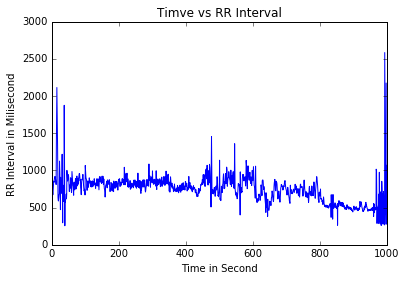

In [2]:
#obtain the hrm file from online
url = 'http://bliss.calit2.net/analysis/device_data/a2abe3083aceab9eeb5617ffeaf7b141.hrm'
response = urllib.request.urlopen(url)
data = response.read()
htmlContent = data.decode('utf-8')
sectionList = re.split("\\[.*\\]", htmlContent)
rrSection = sectionList[-1]
#convert string of rr into list of rr
rrList = rrSection.split('\r\n')
#remove empty string
rrList = list(filter(None, rrList))
#get rid of the last three sentinel values '3999'
rrList = rrList[0:-3]
#convert the strings to numbers
rrList = list(map(int, rrList))
#construct time array from the rr intervals
tList = list()
tList.append(0)
for i in range(len(rrList)-1):
    tList.append(tList[-1] + (rrList[i])/1000)

#plotting the graph
plt.plot(tList, rrList)
plt.xlabel('Time in Second')
plt.ylabel('RR Interval in Milisecond')
plt.title('Timve vs RR Interval')
plt.show()

## Video Processing

Next, we learn how to obtain the same list of RRIT list from PPG signal from videos recorded by fingertips on smartphone. We used ffmpeg instead of the more popular opencv because, while opencv provides wide range of features, we really only need to convert the video into rgb list.

In [ ]:
#set up ffmpeg
FFMPEG_BIN = "ffmpeg"
video = 'your_video_name.mp4'
width = 1920
height = 1080
command = [ FFMPEG_BIN,
            '-i', video,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']
pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)

#return red value from each frame
def captureFrame():
    # read 1920*1080*3 bytes (= 1 frame)
    raw_image = pipe.stdout.read(width*height*3)
    # transform the byte read into a numpy array
    image =  numpy.fromstring(raw_image, dtype='uint8')
    frameTotalByteSize = width*height*3
    if len(image) < frameTotalByteSize:
        return False
    image = image.reshape((width,height,3))
    # throw away the data in the pipe's buffer.
    pipe.stdout.flush()
    totalRed = 0
    for col in range(0, width):
        for row in range(0, height):
            totalRed += image[col][row][0]
    return totalRed/1.0/width/height

rValueList = list()
while True:
    r = captureFrame()
    if not r:
        break
    else:
        rValueList.append(r)

At this point, we are able to obtain a list of average Red color component from each frame of a PPG signal video. We usually save the result because this process is time-consuming.

In [5]:
def writeToFile(fileName):
    file = open('fileName', 'w')
    numpy.savetxt(file, rValueList)

In [6]:
def readFromFile(fileName):
    l =numpy.loadtxt(fileName)
    return l[0], l[1], l[2]

We then focus on getting a RRIT list from the Red color componenet list. Each peak in the red color component list correspond to a real time R-peak, so RRIT(RR interval) would simply be the distance between each peak.

In [ ]:
#obtain rr intervals from red value
def constructRRListFromRedValueList(redValueList, fps):
    timePerFrame = 1.0/fps
    rrList = list()
    lastMaxIndex = False
    for i in range(1, len(redValueList)-1):
        previousSlope = redValueList[i] - redValueList[i-1]
        afterSlope = redValueList[i+1] - redValueList[i]
        # if at that point it is concave down = local max
        if previousSlope*afterSlope < 0 and previousSlope > 0:
            if lastMaxIndex:
                rrInterval = (i-lastMaxIndex)*timePerFrame
                rrList.append(rrInterval)
            lastMaxIndex = i
    return rrList
rrList = constructRRListFromRedValueList(rValueList, 30.0)

We wanted to make sense of these RRITS data, so we graph them against time.

In [ ]:
def constructTimeListFromRRList(rrList, beginT, endT):
    #construct time array from the rr intervals
    tList = list()
    tList.append(float(rrList[0]))
    for i in range(1, len(rrList)):
        tList.append(tList[len(tList)-1] + float(rrList[i]))
    if tList[len(tList)-1]<endT:
        endT=tList[len(tList)-1]

    #limit the time interval
    beginIndex = 0
    endIndex = 0
    i = 0
    while tList[i]<beginT:
        i+=1
    beginIndex = i
    while tList[i]<endT:
        i+=1
    endIndex = i
    tList = tList[beginIndex: endIndex]
    rrList = rrList[beginIndex: endIndex]
    return tList, rrList

def plot(tList, rrList):
    #plotting the graph
    plt.plot(tList, rrList)
    plt.xlabel('Time in Second')
    plt.ylabel('RR Interval in Milisecond')
    plt.title('Timve vs RR Interval')
    plt.show()
tList, rrList = constructTimeListFromRRList(rrList, 0, 50)
total =0
for r in rrList:
    total+=r
plot(tList, rrList)

Before this point, we have been using an arbitrary threshold for finding the RRIT from the Red color list. Next we run through all the logical possible options, and find out the optimal frame window that yields the greatest amount of realistic RRIT and least number of incorrectly identified RRIT.

## R-Peaks Detection

We define the function detectPeak that returns a list of RRIT list depending on the parameter of frameThreshold. This way, we can reuse the code for different threshold.

In [8]:
def detectPeak(colorL, frameThreshold):
    peakL = list()
    colorlistLen = len(colorL)
    for i in range(1, colorlistLen-1):
        biggerThanPrevious = colorL[i] > colorL[i-1]
        biggerThanAfter = colorL[i] > colorL[i+1]
        #if it is a local maximum, then check if it is a RR peak by comparing its maxima interval to frameThreshold
        if biggerThanPrevious and biggerThanAfter:
            for k in range(2, frameThreshold+1):
                if i-k >= 0:
                    if not colorL[i] > colorL[i-k]:
                        #this is not a rr peak
                        break
                if i+k < colorlistLen:
                    if not colorL[i] > colorL[i+k]:
                        #this is not a rr peak
                        break
            else:
                #this IS a rr peak, store the array index
                peakL.append(i)
    return peakL

We also improve upon some of my previous code to create a more readable notebook.

In [9]:
def constructRRIntervalList(peakL):
    return [ (peakL[i]-peakL[i-1])/fps for i in range(1, len(peakL))]

We define a natural logical RRIT to range from .6 to 1.2 and some other helper function.

$$\epsilon^{(i)} = \frac{\text{# of wrong RR}}{\text{# of RR}}$$

This equation is checked by the following function:

In [10]:
def isTrueRRInterval(rrInterval):
    if 0.54 <= rrInterval and rrInterval <= 1.2:
        return True
    else:
        return False

In [11]:
def getPercentError(rrL):
    errorNum = 0
    for rrInterval in rrL:
        if (not isTrueRRInterval(rrInterval)):
            errorNum += 1
    return 100.0*errorNum/len(rrL) if len(rrL) else 100

All these helper functions culminate in the analyzeVideoAndFindPercentErrorList function, which encapsulates everything and return information about the PPG video.

In [12]:
def analyzeVideoAndFindPercentErrorList(fileName):
    rErrorL = []
    gErrorL = []
    bErrorL = []
    rL, gL, bL = readFromFile(fileName)
    for frameThreshold in range(1, 26):
        rRRL = constructRRIntervalList(detectPeak(rL, frameThreshold))
        gRRL = constructRRIntervalList(detectPeak(gL, frameThreshold))
        bRRL = constructRRIntervalList(detectPeak(bL, frameThreshold))
        rErrorL.append(getPercentError(rRRL))
        gErrorL.append(getPercentError(gRRL))
        bErrorL.append(getPercentError(bRRL))
    return rErrorL, gErrorL, bErrorL

Given this function, I could finally begin finding the optimal threshold window. First, this is the list of video that I used:

In [13]:
videoList = ["/home/mong/Desktop/map/map/videos/VID_20150123_172926_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173259_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173329_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173358_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173457_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173556_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173629_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173700_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173757_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173028_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173727_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173527_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173230_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173157_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173127_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173057_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_172956_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_172827_F.mp4.txt"]

Afterward, we process all these video, and find the general best threshold for each color. Red's lowest threshold tend to have the lowest percent error.

# Looking at Data in a Statistical Standpoint

After this, I began looking at the PPG signals at a statistical standpoint. I categorize PPG videos in beams of 50% errors, 25%, 10%...

/home/mong/Desktop/map/map/videos/VID_20150123_173629_F.mp4.txt|red|14     21.21212121212121
/home/mong/Desktop/map/map/videos/VID_20150123_173757_Q.mp4.txt|red|10     0.0
/home/mong/Desktop/map/map/videos/VID_20150123_173556_Q.mp4.txt|red|12     0.0
/home/mong/Desktop/map/map/videos/VID_20150123_173028_F.mp4.txt|red|8     0.0
/home/mong/Desktop/map/map/videos/VID_20150123_173527_F.mp4.txt|red|24     33.333333333333336
/home/mong/Desktop/map/map/videos/VID_20150123_173457_Q.mp4.txt|red|10     0.0
/home/mong/Desktop/map/map/videos/VID_20150123_173329_F.mp4.txt|red|10     53.57142857142857
/home/mong/Desktop/map/map/videos/VID_20150123_172926_F.mp4.txt|red|14     2.5641025641025643
/home/mong/Desktop/map/map/videos/VID_20150123_173057_Q.mp4.txt|red|12     3.225806451612903
/home/mong/Desktop/map/map/videos/VID_20150123_173259_Q.mp4.txt|red|12     0.0
/home/mong/Desktop/map/map/videos/VID_20150123_173727_F.mp4.txt|red|18     14.285714285714286
/home/mong/Desktop/map/map/videos/VID_2015012

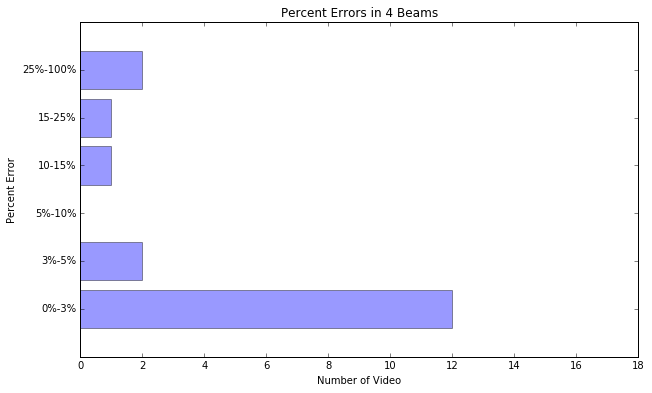

In [14]:
rAvgErrorL = [0 for i in range(0, 25)]
gAvgErrorL = [0 for i in range(0, 25)]
bAvgErrorL = [0 for i in range(0, 25)]
vidPPGL = {}
for video in videoList:
    rErrorL, gErrorL, bErrorL = analyzeVideoAndFindPercentErrorList(video)
    vidPPGL[video+'|red|'+str(rErrorL.index(min(rErrorL))*2+2)] = min(rErrorL)
def isInRange(begin, end, value):
    return begin <= value and value < end
def numOfVidInBeam(begin, end):
    num = 0
    for vidName in vidPPGL:
        if isInRange(begin, end, vidPPGL[vidName]):
            num += 1
    return num
probabilityArray = [numOfVidInBeam(0,3),
                    numOfVidInBeam(3,5),
                    numOfVidInBeam(5,10),
                    numOfVidInBeam(10,15),
                    numOfVidInBeam(15,25),
                    numOfVidInBeam(25,101)]
for v in vidPPGL:
    print(v, '   ',vidPPGL[v])

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.figsize'] = (10, 6)
beams = ('0%-3%', '3%-5%', '5%-10%', '10-15%', '15-25%','25%-100%')
y_pos = numpy.arange(len(beams))

plt.barh(y_pos, probabilityArray,align='center', alpha=0.4)
plt.yticks(y_pos, beams)
plt.xlabel('Number of Video')
plt.ylabel('Percent Error')
plt.xlim(0, len(videoList))
plt.title('Percent Errors in 4 Beams')
plt.show()

We can see that while a few videos are noisy, most are suitable for RRITS calculation.

# The Alignment

After all thes steps, I finally have both the ECG and the PPG signal in the form of a list of RRIT. I then began aligning the signals, that is, finding which part of the either ECG signal correspond to each PPG signal.

## Before we do this, however...

We realize that we need to increase code reusability for enhancing performance and readability. Therefore, we began putting previous codes and rewriting them for better readability.

First we create a class called RRIT (RR interval). It contains one rr interval value and its corresponding time in a signal

In [15]:
class RRIT:
    def __init__(self, time, value):
        self.value = value
        self.time = time
    def __str__(self):
        return '{0:<6.2f} {1:<4}'.format(self.time, self.value)

Next, we define a class called RRSignal extending list that holds many RRITS. That is, it is a special list of RRIT. The object of this class is supposed to record all the information known about the signal.

For alignment, there are 3 main functions: interpolate and align. 

"Interpolate" takes in a time, and returns the mapped RR value on this signal.

"Align" takes in two signal, one from ecg and one from ppg, and interpolates each RRIT from the ppg onto the ecg. It returns a total alignment distance.

"AlignMultiple" builds upon "align" and align a ppg's RRIT signal with multiple ecg, and return the one with minimal alignment distance, that is, the ecg signal the ppg mostly likely to be originated from.

In [16]:
def withinRange(begin, endExclude, value):
    return begin <= value and value < endExclude

class RRSignal(list):
    def __init__(self, rrValueList, name, color=None, threshold=None, percentError=None):
        list.__init__(self)
        self.constructRRITList(rrValueList)
        self.name = name
        self.color = color
        self.threshold = threshold
        self.percentError = percentError
    def getRRITList(self):
        return [RRIT.value for RRIT in self]
    def getTimeList(self):
        return [RRIT.time for RRIT in self]
    def duration(self, beginIndex=-1, endIndex=-1):
        beginT = self[beginIndex].time if withinRange(0, len(self), beginIndex) else self[0].time
        endT = self[endIndex-1].time if withinRange(0, len(self), endIndex-1) else self[-1].time
        return endT - beginT
    #this function is only used internally
    #create a corresponding RRIT list from the rr value list
    #rr value in ms; time in second
    def constructRRITList(self, rrValueList):
        firstRRValue = round(rrValueList[0]*1000)
        self.append(RRIT(0, firstRRValue))
        pastTime = 0
        for i in range(1, len(rrValueList)):
            curTime = pastTime + rrValueList[i-1]
            curRRValue = round(rrValueList[i]*1000)
            curRRIT = RRIT(curTime, curRRValue)
            self.append(curRRIT)
            pastTime = curTime
    def interpolate(self, targetTime, indexOffset=0):
        targetTime = self[indexOffset].time + targetTime
        #targetTime is not in range of array
        if targetTime < self[0].time or self[-1].time < targetTime:
            return -1
        #if targetTime is in range, locate its position on this set
        leftIndex = -1
        for i in range(len(self)):
            if targetTime < self[i].time:
                leftIndex = i-1
                break
        leftRRIT = self[leftIndex]
        rightRRIT = self[leftIndex+1]
        slope = (rightRRIT.value - leftRRIT.value) / (rightRRIT.time - leftRRIT.time)
        deltaTime = targetTime - leftRRIT.time
        deltaValue = deltaTime * slope
        return leftRRIT.value + deltaValue
    def align(ppg, ecg):
        minAlignmentDistance = 100000000
        bestFitTime = None
        for i in range(len(ecg)):
            if ppg.duration() > ecg.duration(beginIndex=i):
                break
            alignmentDistance = 0
            for ppgRRIT in ppg:
                interpolatedValue = ecg.interpolate(ppgRRIT.time, indexOffset=i)
                alignmentDistance += abs(interpolatedValue - ppgRRIT.value)
            if alignmentDistance < minAlignmentDistance:
                minAlignmentDistance = alignmentDistance
                bestFitTime = ecg[i].time
        return bestFitTime, minAlignmentDistance
    def alignMultiple(ppg, *ecgSignalList):
        minAlignmentDistance = 1000000
        bestFitTime = None
        bestFitEcg = None
        for ecg in ecgSignalList:
            alignmentTime, alignmentDistance = RRSignal.align(ppg, ecg)
            if alignmentDistance < minAlignmentDistance:
                minAlignmentDistance = alignmentDistance
                bestFitTime = alignmentTime
                bestFitEcg = ecg
        return bestFitEcg, bestFitTime, minAlignmentDistance

The following functions (mostly previous functions rewritten) are used in translating the rgb values of txt files to a list of RRIT. It culminates in the function "analyzeVideoAndObtainBestRedRRInterval."

In [17]:
def readFromFile(fileName):
    l =numpy.loadtxt(fileName)
    return l[0], l[1], l[2]

In [18]:
def detectPeak(colorL, frameThreshold):
    peakL = list()
    colorlistLen = len(colorL)
    for i in range(1, colorlistLen-1):
        biggerThanPrevious = colorL[i] > colorL[i-1]
        biggerThanAfter = colorL[i] > colorL[i+1]
        #if it is a local maximum, then check if it is a RR peak by comparing its maxima interval to frameThreshold
        if biggerThanPrevious and biggerThanAfter:
            for k in range(2, frameThreshold+1):
                if i-k >= 0:
                    if not colorL[i] > colorL[i-k]:
                        #this is not a rr peak
                        break
                if i+k < colorlistLen:
                    if not colorL[i] > colorL[i+k]:
                        #this is not a rr peak
                        break
            else:
                #this IS a rr peak, store the array index
                peakL.append(i)
    return peakL

In [19]:
def constructRRIntervalList(peakL):
    return [ (peakL[i]-peakL[i-1])/fps for i in range(1, len(peakL))]

In [20]:
def isTrueRRInterval(rrInterval):
    if 0.54 <= rrInterval and rrInterval <= 1.2:
        return True
    else:
        return False

In [21]:
def getPercentError(rrL):
    errorNum = 0
    for rrInterval in rrL:
        if not isTrueRRInterval(rrInterval):
            errorNum += 1
    return 100.0*errorNum/len(rrL) if len(rrL) else 0

In [22]:
def analyzeVideoAndObtainBestRedRRInterval(fileName):
    rErrorL = []
    rL, gL, bL = readFromFile(fileName)
    bestRRL = None
    bestPercentErrorSoFar = 101
    bestFrameThreshold = None
    lowestPercentError = None
    for frameThreshold in range(1, 26):
        rRRL = constructRRIntervalList(detectPeak(rL, frameThreshold))
        percentError = getPercentError(rRRL)
        if percentError < bestPercentErrorSoFar:
            bestPercentErrorSoFar = percentError
            bestRRL = rRRL
            bestFrameThreshold = frameThreshold*2
            lowestPercentError = percentError
    return bestRRL, lowestPercentError, bestFrameThreshold

In [23]:
def convertStrLToSecFloatL(array):
    for i in range(len(array)):
        array[i] = float(array[i])/1000.0
    return array

## Begin the alignment

With these tools, we can finally begin the alignment. First, we process the 2 ECG signals.

In [24]:
#first hrm file
f = open('/home/mong/Desktop/map/map/videos/15012301_GIO.hrm', 'r')
inputSectionList = f.read().split('\n\n')
rrSection = inputSectionList[-1]
rrData = rrSection.split('\n')
#get rid of header
ecg1 = rrData[1:-1]
ecg1 = convertStrLToSecFloatL (ecg1)
ecg1 = RRSignal(ecg1, '15012301_GIO.hrm ecg1')

#second hrm file
f = open('/home/mong/Desktop/map/map/videos/15012301_GLO.hrm', 'r')
inputSectionList = f.read().split('\n\n')
rrSection = inputSectionList[-2]
rrData = rrSection.split('\n')
#get rid of header
ecg2 = rrData[1:]
ecg2 = convertStrLToSecFloatL (ecg2)
ecg2 = RRSignal(ecg2, '15012301_GLO.hrm ecg2')

In [25]:
videoList = ["/home/mong/Desktop/map/map/videos/VID_20150123_172926_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173259_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173329_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173358_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/new_VID_20150123_173427_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173457_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173556_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173629_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173700_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173757_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173028_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/new_VID_20150123_172857_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173727_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173527_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173230_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173157_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173127_F.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_173057_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_172956_Q.mp4.txt",
                "/home/mong/Desktop/map/map/videos/VID_20150123_172827_F.mp4.txt"]

Here we align each ppg with each two ecg. 

In [26]:
ecg1Result = []
ecg2Result = []
for vidName in videoList:
    print("Aligning",os.path.basename(vidName))
    ppgRRSignal, percentError, threshold = analyzeVideoAndObtainBestRedRRInterval(vidName)
    ppgRRSignal = RRSignal(ppgRRSignal, os.path.basename(vidName), color='red', percentError=percentError, threshold=threshold)
    bestFitEcg, bestFitTime, distance = RRSignal.alignMultiple(ppgRRSignal, ecg1, ecg2)
    if bestFitEcg.name == '15012301_GIO.hrm ecg1':
        ecg1Result.append((bestFitTime, distance, ppgRRSignal))
    else:
        ecg2Result.append((bestFitTime, distance, ppgRRSignal))
ecg1Result = sorted(ecg1Result, key=lambda ppg: ppg[0])
ecg2Result = sorted(ecg2Result, key=lambda ppg: ppg[0])

Aligning VID_20150123_172926_F.mp4.txt
Aligning VID_20150123_173259_Q.mp4.txt
Aligning VID_20150123_173329_F.mp4.txt
Aligning VID_20150123_173358_Q.mp4.txt
Aligning new_VID_20150123_173427_F.mp4.txt
Aligning VID_20150123_173457_Q.mp4.txt
Aligning VID_20150123_173556_Q.mp4.txt
Aligning VID_20150123_173629_F.mp4.txt
Aligning VID_20150123_173700_Q.mp4.txt
Aligning VID_20150123_173757_Q.mp4.txt
Aligning VID_20150123_173028_F.mp4.txt
Aligning new_VID_20150123_172857_Q.mp4.txt
Aligning VID_20150123_173727_F.mp4.txt
Aligning VID_20150123_173527_F.mp4.txt
Aligning VID_20150123_173230_F.mp4.txt
Aligning VID_20150123_173157_Q.mp4.txt
Aligning VID_20150123_173127_F.mp4.txt
Aligning VID_20150123_173057_Q.mp4.txt
Aligning VID_20150123_172956_Q.mp4.txt
Aligning VID_20150123_172827_F.mp4.txt


# Result of the Alignment

## 15012301_GIO.hrm

In [27]:
for alignment in ecg1Result:
    s = 'At t={0:>5.1f} to {1:>5.1f} is {2:>33} with %error of {3:>5.2f} with distance of {4:>4.1f}'.format(
        alignment[0],
        alignment[0]+alignment[2].duration(),
        alignment[2].name,
        alignment[2].percentError,
        alignment[1])
    print(s)

At t= 26.8 to  55.2 is new_VID_20150123_172857_Q.mp4.txt with %error of  0.00 with distance of 953.6
At t= 84.7 to 112.0 is     VID_20150123_172956_Q.mp4.txt with %error of  0.00 with distance of 843.4
At t=145.3 to 173.4 is     VID_20150123_173057_Q.mp4.txt with %error of  3.23 with distance of 1173.6
At t=205.4 to 232.8 is     VID_20150123_173157_Q.mp4.txt with %error of  0.00 with distance of 556.2
At t=267.3 to 294.5 is     VID_20150123_173259_Q.mp4.txt with %error of  0.00 with distance of 372.0
At t=278.9 to 306.0 is     VID_20150123_173527_F.mp4.txt with %error of 33.33 with distance of 10283.3
At t=326.3 to 353.1 is     VID_20150123_173358_Q.mp4.txt with %error of  0.00 with distance of 563.8
At t=349.4 to 377.3 is     VID_20150123_173329_F.mp4.txt with %error of 53.57 with distance of 13860.6
At t=384.9 to 412.9 is     VID_20150123_173457_Q.mp4.txt with %error of  0.00 with distance of 564.6
At t=444.3 to 472.7 is     VID_20150123_173556_Q.mp4.txt with %error of  0.00 with dis

## 15012301_GLO.hrm

In [28]:
for alignment in ecg2Result:
    s = 'At t={0:>5.1f} to {1:>5.1f} is {2:>33} with %error of {3:>5.2f} with distance of {4:>4.1f}'.format(
        alignment[0],
        alignment[0]+alignment[2].duration(),
        alignment[2].name,
        alignment[2].percentError,
        alignment[1])
    print(s)

At t= 36.6 to  65.1 is     VID_20150123_172827_F.mp4.txt with %error of  2.33 with distance of 1553.4
At t= 96.2 to 122.8 is     VID_20150123_172926_F.mp4.txt with %error of  2.56 with distance of 1304.5
At t=157.0 to 184.7 is     VID_20150123_173028_F.mp4.txt with %error of  0.00 with distance of 794.4
At t=161.9 to 191.2 is new_VID_20150123_173427_F.mp4.txt with %error of 59.38 with distance of 17719.0
At t=216.3 to 246.1 is     VID_20150123_173127_F.mp4.txt with %error of  2.33 with distance of 1440.6
At t=278.9 to 307.2 is     VID_20150123_173230_F.mp4.txt with %error of  4.76 with distance of 1237.2
At t=448.4 to 472.8 is     VID_20150123_173727_F.mp4.txt with %error of 14.29 with distance of 6158.1
At t=519.4 to 546.8 is     VID_20150123_173629_F.mp4.txt with %error of 21.21 with distance of 7407.8


# Visual Confirmation

Here we create graphical confirmation of the alignment. For each PPG's RRITS, we graph its supposedly corresponding RRITS on either ECG signals.

In [29]:
def constructTimeListFromRRInterval(rrList):
    #construct time array from the rr intervals
    tList = []
    tList.append(float(rrList[0]))
    for i in range(1, len(rrList)):
        tList.append(tList[-1] + float(rrList[i]))
    return tList

## 15012301_GIO.hrm

new_VID_20150123_172857_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  953.6457622890721


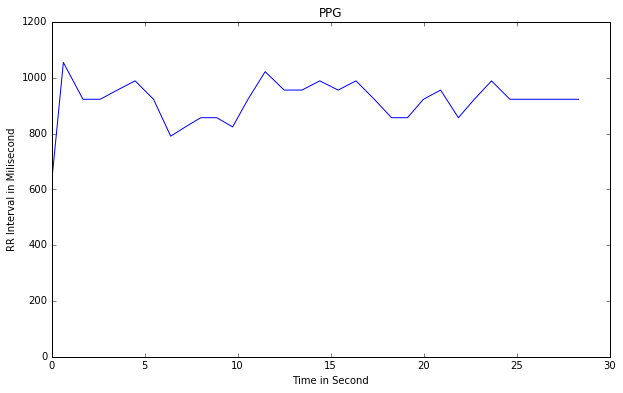

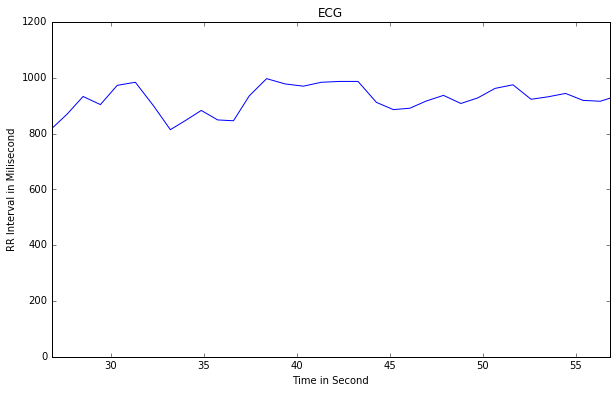

VID_20150123_172956_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  843.4060107566347


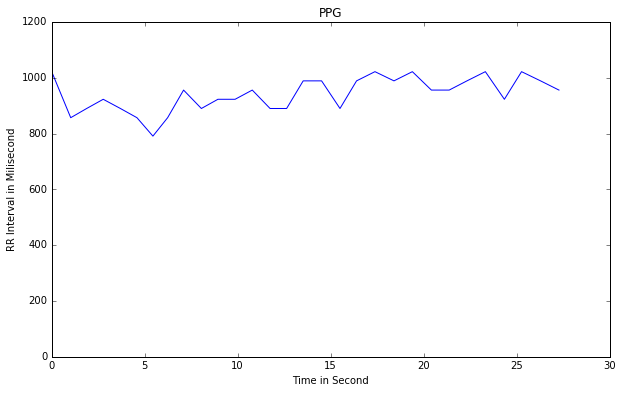

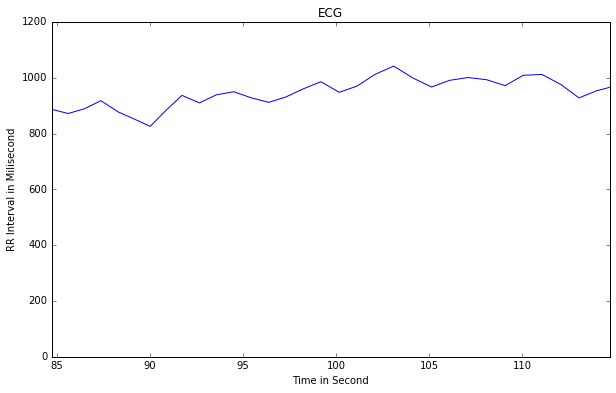

VID_20150123_173057_Q.mp4.txt
Percent Error for the RRITS in this video: 3.225806451612903
Alignment Distance:  1173.631978322339


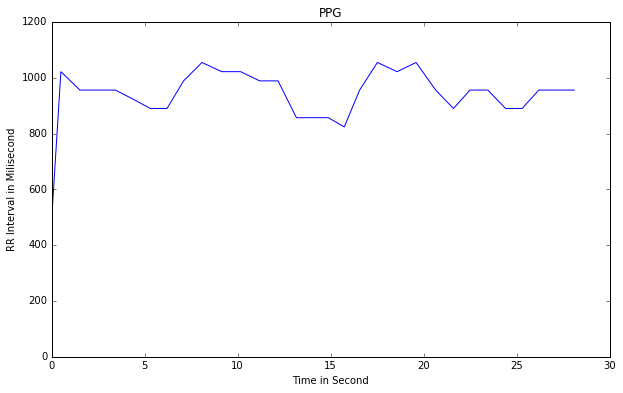

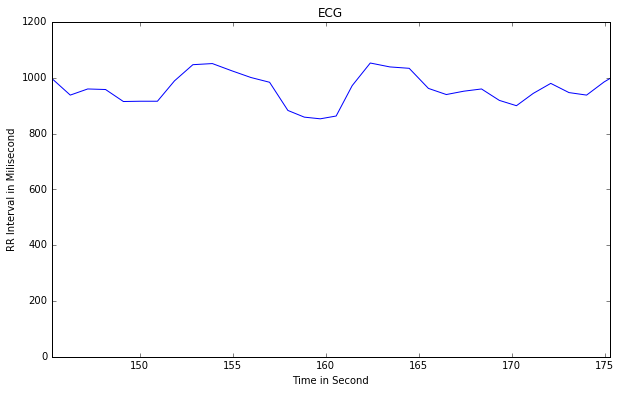

VID_20150123_173157_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  556.1584386526453


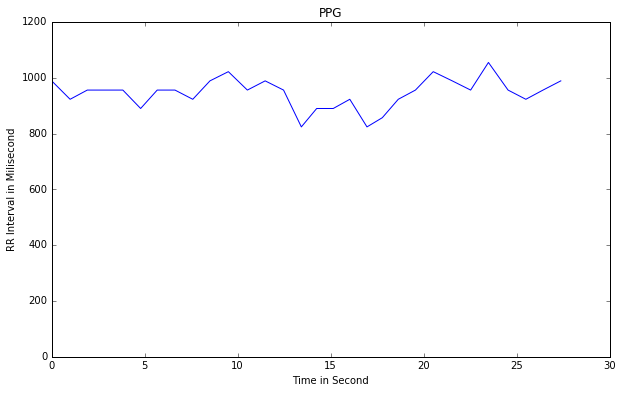

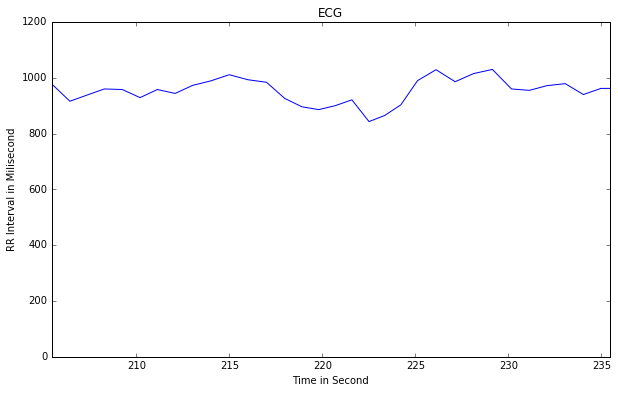

VID_20150123_173259_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  372.0277972281509


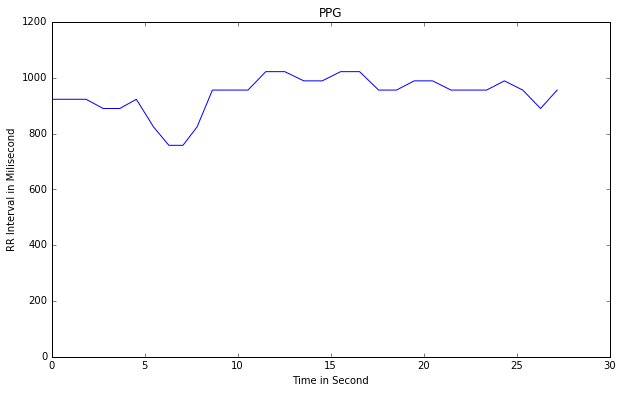

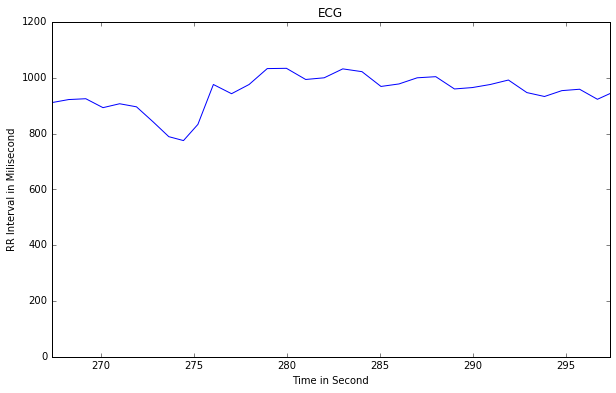

VID_20150123_173527_F.mp4.txt
Percent Error for the RRITS in this video: 33.333333333333336
Alignment Distance:  10283.252014782805


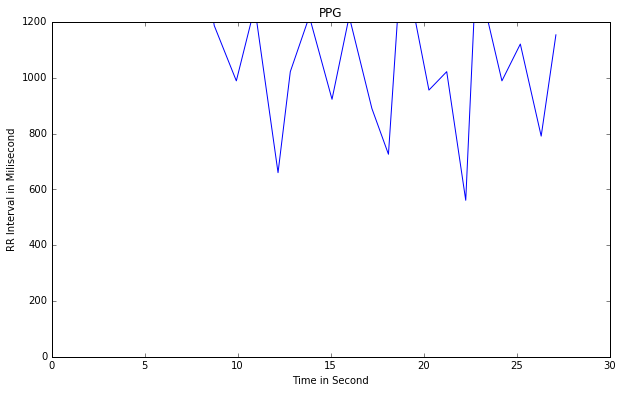

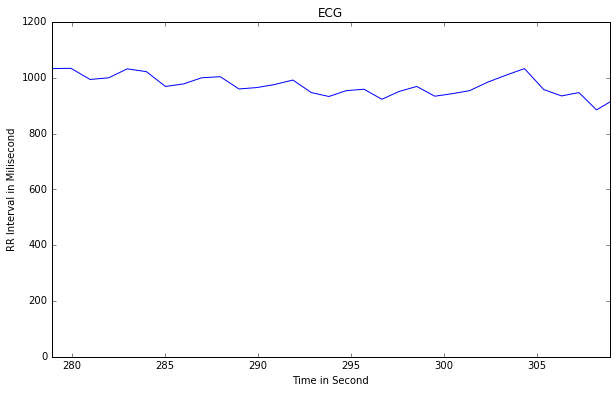

VID_20150123_173358_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  563.8135614303249


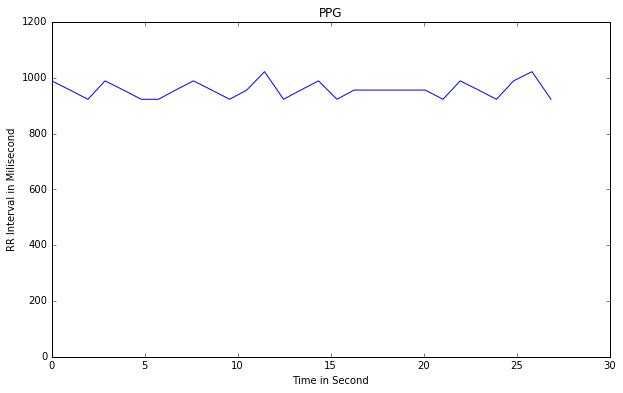

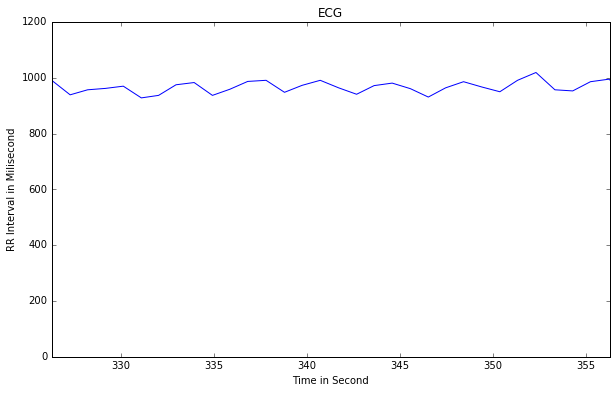

VID_20150123_173329_F.mp4.txt
Percent Error for the RRITS in this video: 53.57142857142857
Alignment Distance:  13860.570403447828


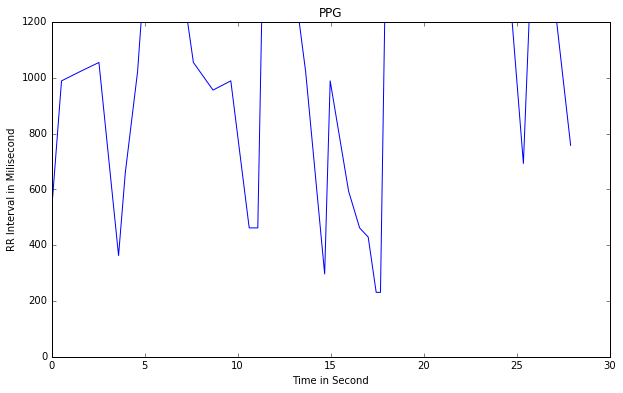

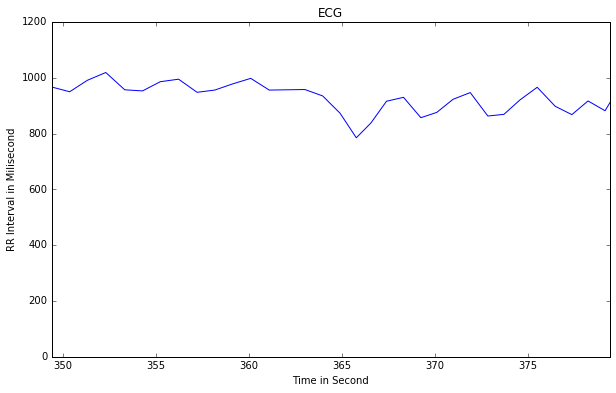

VID_20150123_173457_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  564.5634020773489


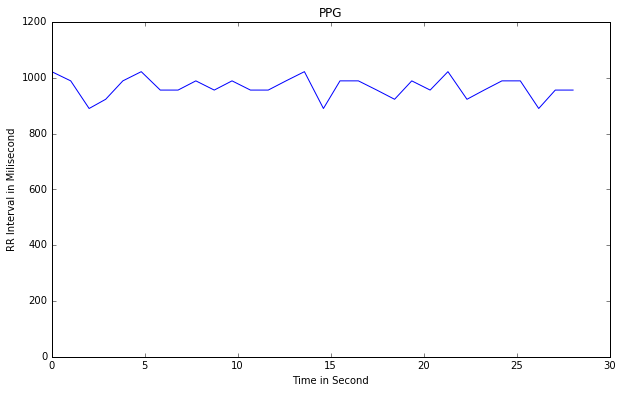

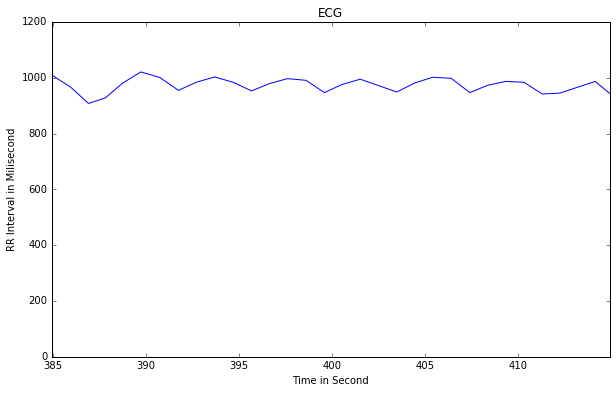

VID_20150123_173556_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  333.19363884106895


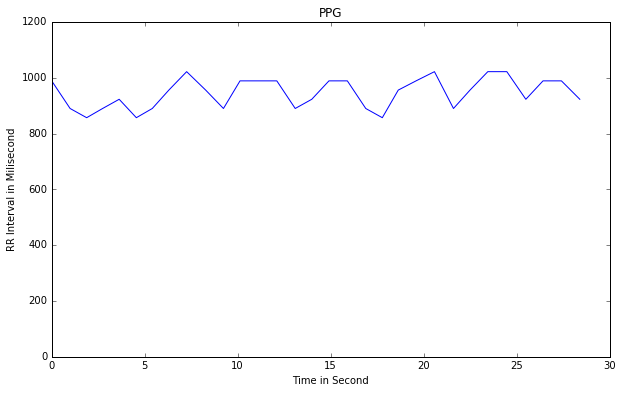

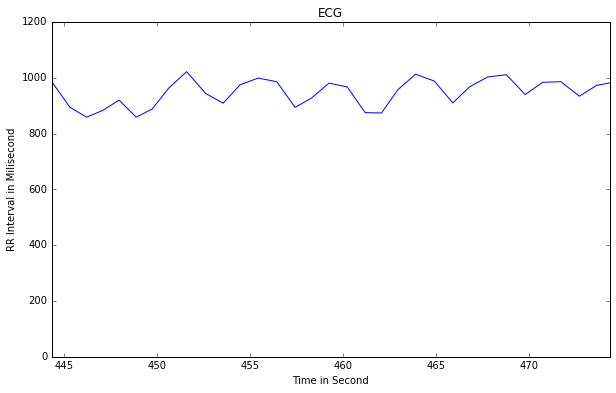

VID_20150123_173700_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  514.0767044829404


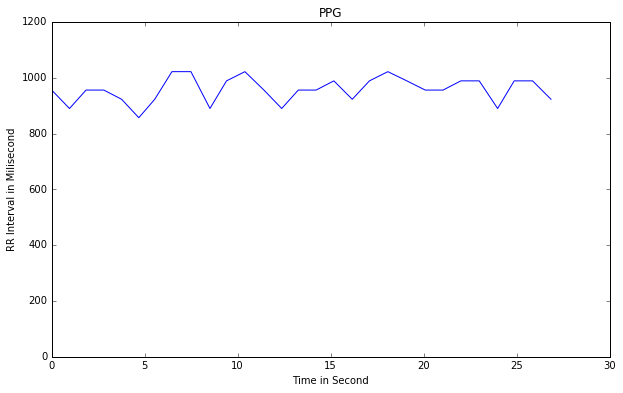

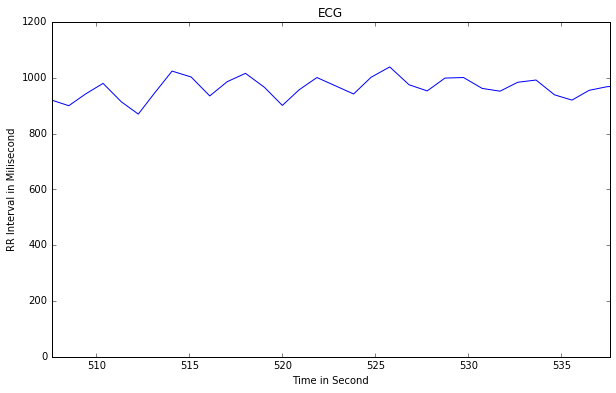

VID_20150123_173757_Q.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  622.6045157875539


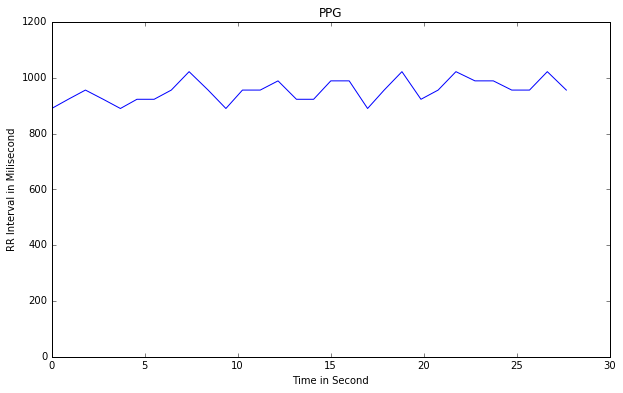

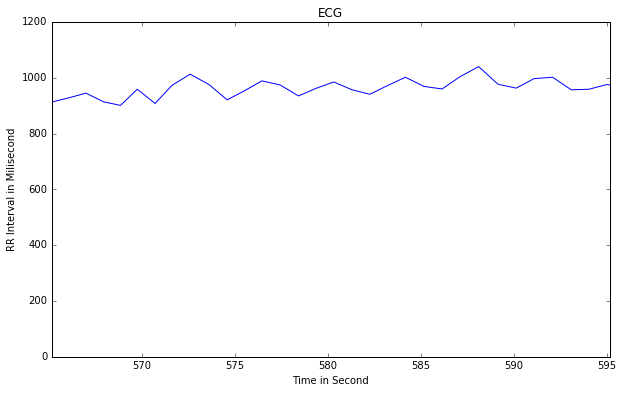

In [30]:
ecg1TimeList = ecg1.getTimeList()
ecg1RRITList = ecg1.getRRITList()
ecg2TimeList = ecg2.getTimeList()
ecg2RRITList = ecg2.getRRITList()

#first for ecg1, which represents 15012301_GIO.hrm
for alignment in ecg1Result:
    time = alignment[0]
    distance = alignment[1]
    ppgRRITSignal = alignment[2]
    print(os.path.basename(ppgRRITSignal.name))
    print('Percent Error for the RRITS in this video:', ppgRRITSignal.percentError)
    print('Alignment Distance: ', distance)
    plt.plot(ppgRRITSignal.getTimeList(), ppgRRITSignal.getRRITList())
    plt.xlabel('Time in Second')
    plt.ylabel('RR Interval in Milisecond')
    plt.title('Timv vs RR Interval')
    plt.xlim(0,30)
    plt.ylim(0, 1200)
    plt.title("PPG")
    plt.show()
    plt.plot(ecg1TimeList, ecg1RRITList)
    plt.xlabel('Time in Second')
    plt.ylabel('RR Interval in Milisecond')
    plt.title('Time vs RR Interval')
    plt.xlim(time, time+30)
    plt.ylim(0, 1200)
    plt.title("ECG")
    plt.show()

## 15012301_GLO.hrm

VID_20150123_172827_F.mp4.txt
Percent Error for the RRITS in this video: 2.3255813953488373
Alignment Distance:  1553.3987154150086


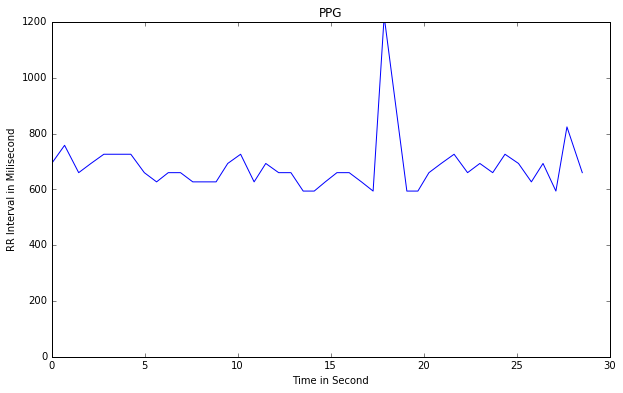

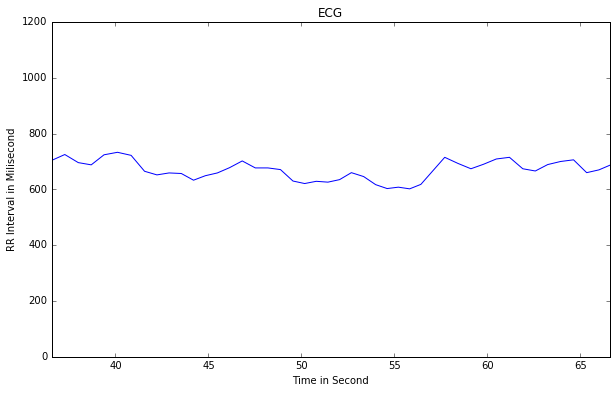

VID_20150123_172926_F.mp4.txt
Percent Error for the RRITS in this video: 2.5641025641025643
Alignment Distance:  1304.5355055541277


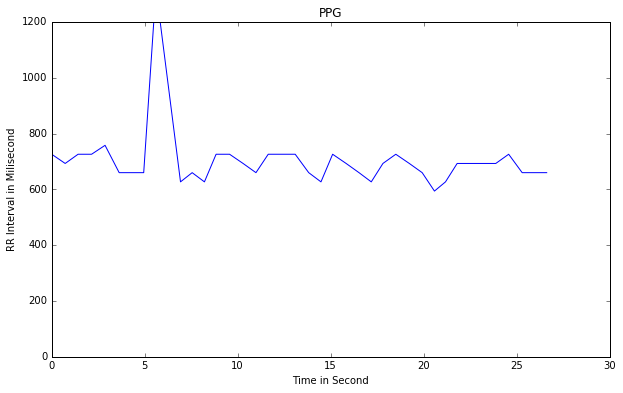

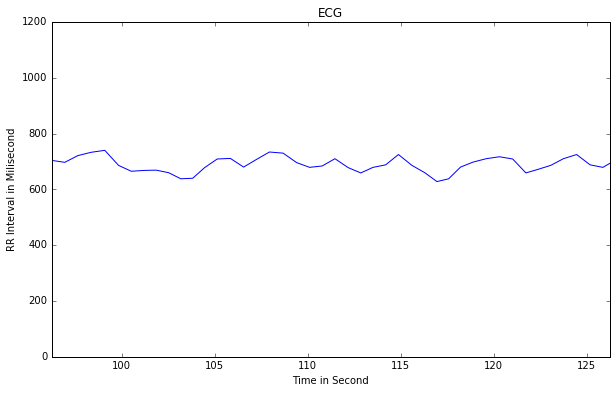

VID_20150123_173028_F.mp4.txt
Percent Error for the RRITS in this video: 0.0
Alignment Distance:  794.4187166365408


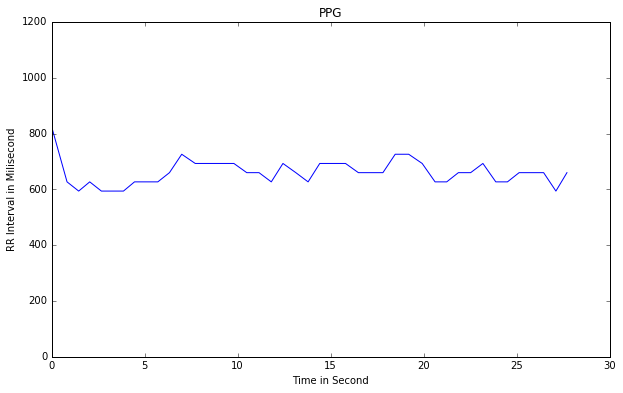

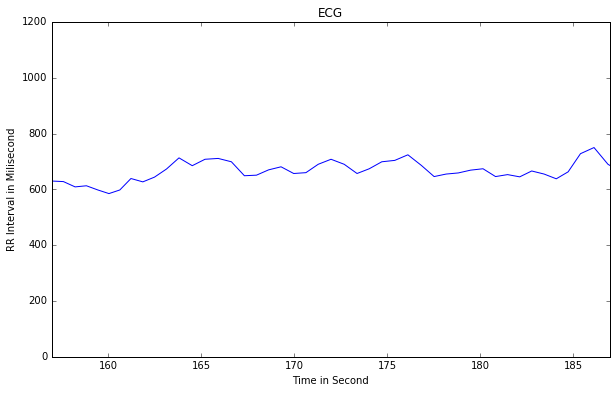

new_VID_20150123_173427_F.mp4.txt
Percent Error for the RRITS in this video: 59.375
Alignment Distance:  17718.95734043981


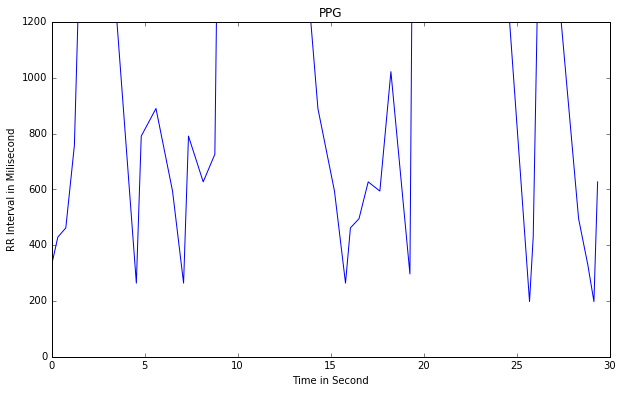

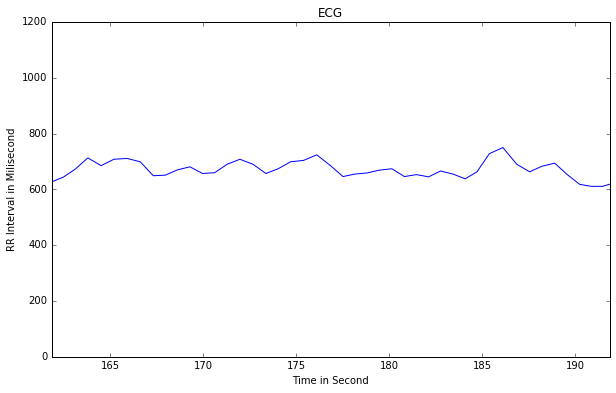

VID_20150123_173127_F.mp4.txt
Percent Error for the RRITS in this video: 2.3255813953488373
Alignment Distance:  1440.565370449147


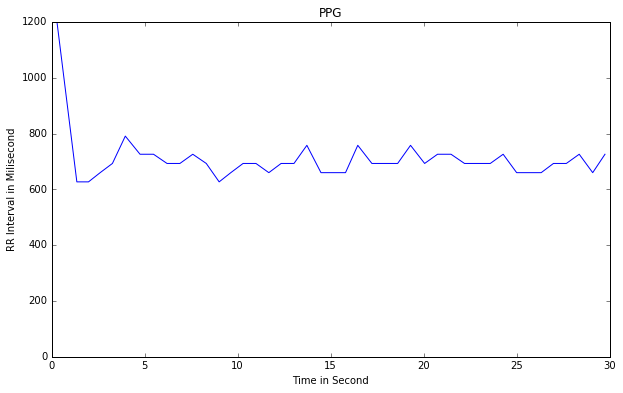

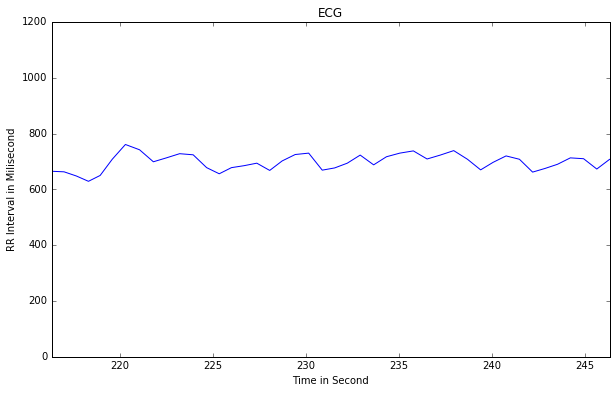

VID_20150123_173230_F.mp4.txt
Percent Error for the RRITS in this video: 4.761904761904762
Alignment Distance:  1237.2418962301397


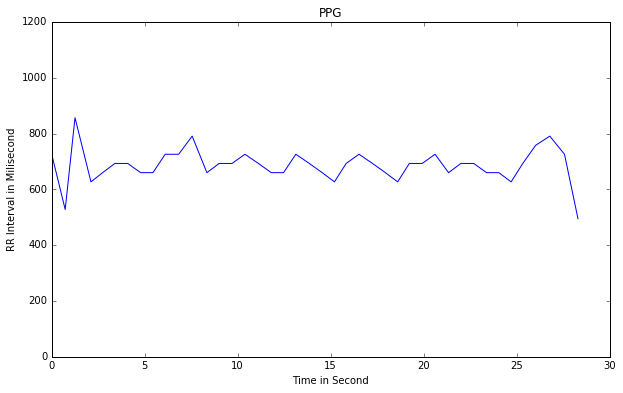

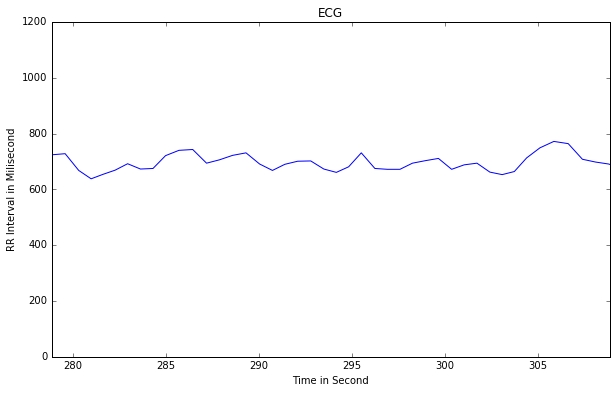

VID_20150123_173727_F.mp4.txt
Percent Error for the RRITS in this video: 14.285714285714286
Alignment Distance:  6158.145437806068


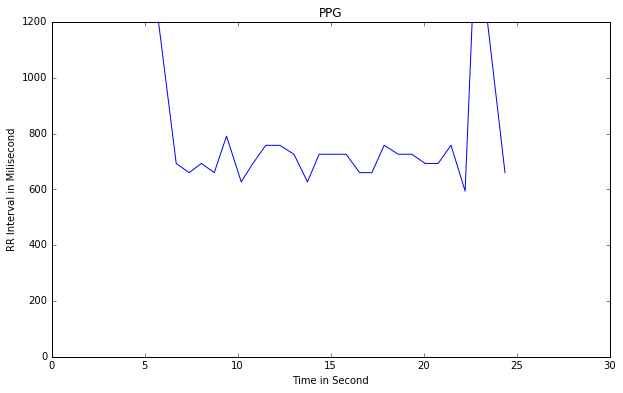

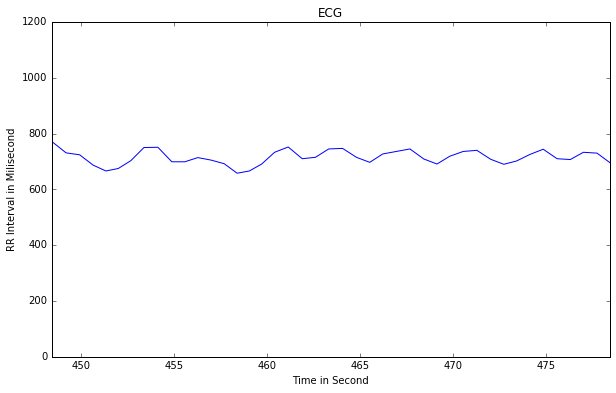

VID_20150123_173629_F.mp4.txt
Percent Error for the RRITS in this video: 21.21212121212121
Alignment Distance:  7407.786013130281


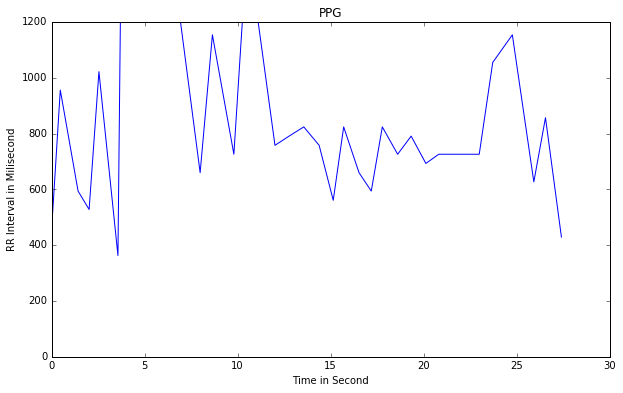

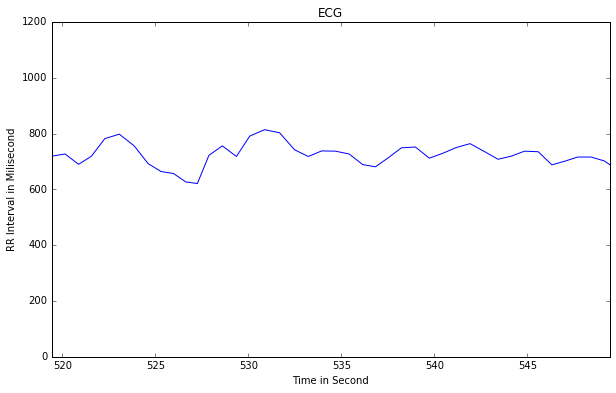

In [31]:
for alignment in ecg2Result:
    time = alignment[0]
    distance = alignment[1]
    ppgRRITSignal = alignment[2]
    print(os.path.basename(ppgRRITSignal.name))
    print('Percent Error for the RRITS in this video:', ppgRRITSignal.percentError)
    print('Alignment Distance: ', distance)
    plt.plot(ppgRRITSignal.getTimeList(), ppgRRITSignal.getRRITList())
    plt.xlabel('Time in Second')
    plt.ylabel('RR Interval in Milisecond')
    plt.title('Timve vs RR Interval')
    plt.xlim(0,30)
    plt.ylim(0, 1200)
    plt.title("PPG")
    plt.show()
    plt.plot(ecg2TimeList, ecg2RRITList)
    plt.xlabel('Time in Second')
    plt.ylabel('RR Interval in Milisecond')
    plt.title('Timve vs RR Interval')
    plt.xlim(time, time+30)
    plt.ylim(0, 1200)
    plt.title("ECG")
    plt.show()

Overall, we see a positive correlation between the PPG signal's RRIT identification percent error and its success in aligning to the ECG RRIT signal. In addition, we have now been able to find out the section of ECG that is equivalent to each PPG.

# Creating My Own PPG signals

After this, I also begin recording my own PPG video. I pleace my right index finger on the flashlight of my smartphone while recording through the camera. Here we have two ppg signal I recorded on my smartphone. I convert these two to RRSignal and graph them.

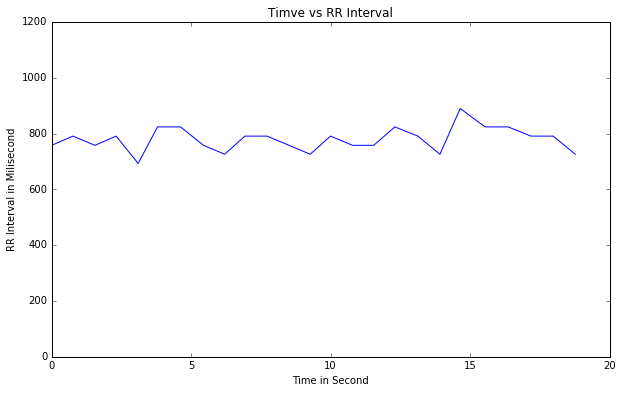

In [32]:
vidName = "/home/mong/Desktop/map/map/videos/ccc.3gp.txt"
ppgRRSignal, percentError, threshold = analyzeVideoAndObtainBestRedRRInterval(vidName)
ppgRRSignal = RRSignal(ppgRRSignal, os.path.basename(vidName), color='red', percentError=percentError, threshold=threshold)
plt.plot(ppgRRSignal.getTimeList(), ppgRRSignal.getRRITList())
plt.xlabel('Time in Second')
plt.ylabel('RR Interval in Milisecond')
plt.title('Timve vs RR Interval')
plt.ylim(0, 1200)
plt.show()

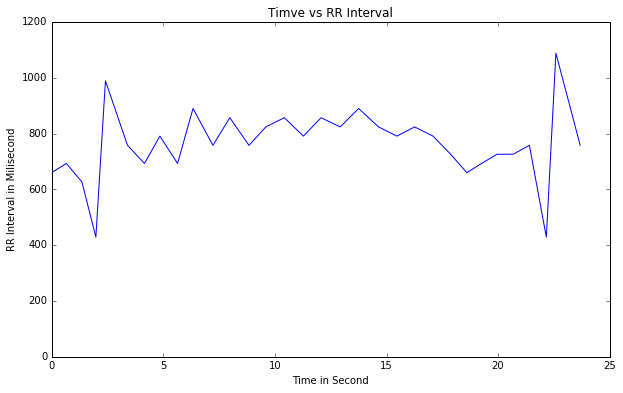

In [33]:
vidName = "/home/mong/Desktop/map/map/videos/ddd.3gp.txt"
ppgRRSignal, percentError, threshold = analyzeVideoAndObtainBestRedRRInterval(vidName)
ppgRRSignal = RRSignal(ppgRRSignal, os.path.basename(vidName), color='red', percentError=percentError, threshold=threshold)
plt.plot(ppgRRSignal.getTimeList(), ppgRRSignal.getRRITList())
plt.xlabel('Time in Second')
plt.ylabel('RR Interval in Milisecond')
plt.title('Timve vs RR Interval')
plt.ylim(0, 1200)
plt.show()

# Conclusion

This was an extrememly rewarding experience. Not only did I learn a lot about how the heart and the physiological signals it generate every moment, I learned how to manipulate and analyze these data. I had a glimpse in what real world research is like, and make me more determined on this long learning road. I learned that readability is important, and that sometimes, spending more time to writing classes and function saves more time in the long run, despite the longer time to write them in short time.

I want to thank Dr. Giorgio Quer again for mentoring me. I also want to thank University of California, San Diego, and the San Diego Supercomputer Center for providing such a wonderful opportunity.